# COURSE: Master statistics and machine learning: Intuition, Math, code
##### COURSE URL: udemy.com/course/statsml_x/?couponCode=202304 
## SECTION: The t-test family
### VIDEO: Permutation testing
#### TEACHER: Mike X Cohen, sincxpress.com

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

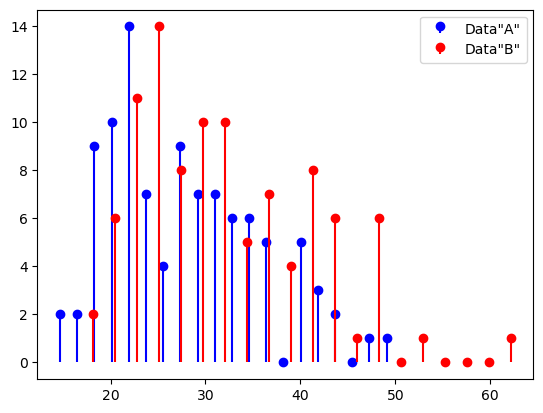

In [2]:
## simulate two distributions

# number of trials
N = 100 # 100 data points per dataset/100 trials

# dataset "A"
# start as normally distributed values
r = np.random.randn(N)
r[r>0] = np.log(1+r[r>0]) # take log of positive values
dataA = 26-r*10 # random mutations, just arbitrary to make different looking data

# get histogram values for later comparison
yA,xA = np.histogram(dataA,20) # data A in 20 bins
xA = (xA[:-1]+xA[1:])/2

# dataset "B"
r = np.random.randn(N)
r[r>0] = np.log(1+r[r>0])
dataB = 30-r*10 # same arbitrary mutations, use a different offset of 30 for data B instead of 26 as for data A

#get histogram values of dataset B for later comparison
yB,xB = np.histogram(dataB,20)
xB = (xB[:-1]+xB[1:])/2

# plot the datasets shown on a stem plot
plt.stem(xA,yA,'b',markerfmt='bo',basefmt=' ',label='Data"A"')
plt.stem(xB,yB,'r',markerfmt='ro',basefmt=' ',label='Data"B"')
plt.legend()
plt.show()

In [3]:
## mix trials together

# Now we have two datasets A and B and want to compare them to see if there is a significant difference in the means of the two sets.

# concatenate trials - combine the data sets into one set - 200 elements
alldata = np.hstack((dataA,dataB))

# condition labels - we need a way to identify which points come from dataset A and which are from B
conds = np.hstack((np.ones(N),2*np.ones(N))) # represents [1,1,1....,2,2,2....] to label whether the point is condition 1 or condition 2

In [25]:
## generate one null hypothesis scenario

# The null hypothesis would be that the two datasets would have similar means (i.e. the come from the same distribution) - if you subtract the difference of them it should be zero


# random permutation - fake condition labels, a random ordering of numbers
fakeconds = np.random.permutation(N*2) # just shuffles numbers 0 to 199 randomly, we do this to simply get a set of 200 elements to use below

# shuffled condition labels - apply 1s to numbers less than 100 and 2s to numbers greater than 1
# this changes the labeling to be different from above - the labels do not match the original data set they belonged to
fakeconds[fakeconds<N] = 1
fakeconds[fakeconds>1] = 2 # take all the remaining unconverted 1s and make them 2s
# [1,2,2,2,1,1,1,1,1,2,2,1,1,...] data is preserved, but the labels are randomly assigned to data points.


# these two means should be different since the original data sets generated have different means (due to the different offsets)
# we compare the means of the data from sets A and B with the original labels (1 or 2)
print([np.mean(alldata[conds==1]), np.mean(alldata[conds==2])]) # use original condition labels to get a and b sets

# compare randomly selected samples using fake labels and confirm if mean is different
print([np.mean(alldata[fakeconds==1]), np.mean(alldata[fakeconds==2])]) # use random conditions to compare randomly selected data points from either a or b sets and compare means

#### This is one random shuffling - we need to do this many times to generate a null hypothesis distribution

[27.64390839095483, 32.27025277749127]
[30.997002953336214, 28.917158215109886]


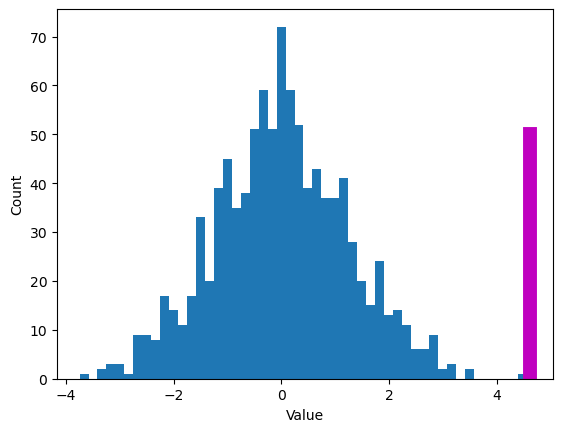

In [26]:
## and now a distribution of null hypothesis values

## we need to shuffle many times (1000 times here) and generate a null hypothesis distribution from taking the difference of means from each shuffle of two datasets
## The difference distribution generated should peak at 0 and that should be the center of the distribution created.

nPerms = 1000
permdiffs = np.zeros(nPerms)

for permi in range(nPerms):
    # same as one shuffle code from previous block - make random fake labels to mask on the data.
    fconds = np.random.permutation(N*2) # just generate two hundred elements to use as fake labels
    fconds[fconds<N] = 1
    fconds[fconds>1] = 2
    # store the difference in random samples from the data groups to build a distribution from
    permdiffs[permi] = np.mean(alldata[fconds==2]) - np.mean(alldata[fconds==1])


# plot the distribution of H0 values - will resemble a gaussian with zero at the peak
plt.hist(permdiffs,50)

# and plot the observed value on top, we compare the means of the original data labeled with original condition
# note that we don't compute a t-value, this is just the numerator. Any scaling issues are addressed in the permuations above as well and baked in - so it is robust to scaling issues. Since we are making a null hypothesis distribution that includes any weird stuff happening in the data.
obsval = np.mean(alldata[conds==2]) - np.mean(alldata[conds==1])
plt.plot([obsval, obsval],[0, 50],'m',linewidth=10) # magenta vertical line on plot represents observed mean diff
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [28]:
## two methods of evaluating statistical significance

## Is the magenta line above far enough away from the center of the H_0 distribution to qualify as statistically significant (if so then we reject the null hypothesis)

# Z-value method - subtract the mean of the diffs in h0 distribution from the observed value mean diff (permdiffs are null hypothesis distribution vals)
zVal = ( obsval-np.mean(permdiffs) ) / np.std(permdiffs,ddof=1) #std dev of the null distribution, get normalized z value
p = 1-stats.norm.cdf(abs(zVal)) # p-value, cumulative distribution function tells us how much area a normal distribution there is under the observed z-value

# p-value count method
# count null hypothesis values in distribution larger than the observed value, divide by num trials
pCount = sum(permdiffs>obsval)/nPerms

print(p,pCount)
# Note that when the null hypothesis is roughly Gaussian the two methods will yield very similar results

0.00010081061110822631 0.0


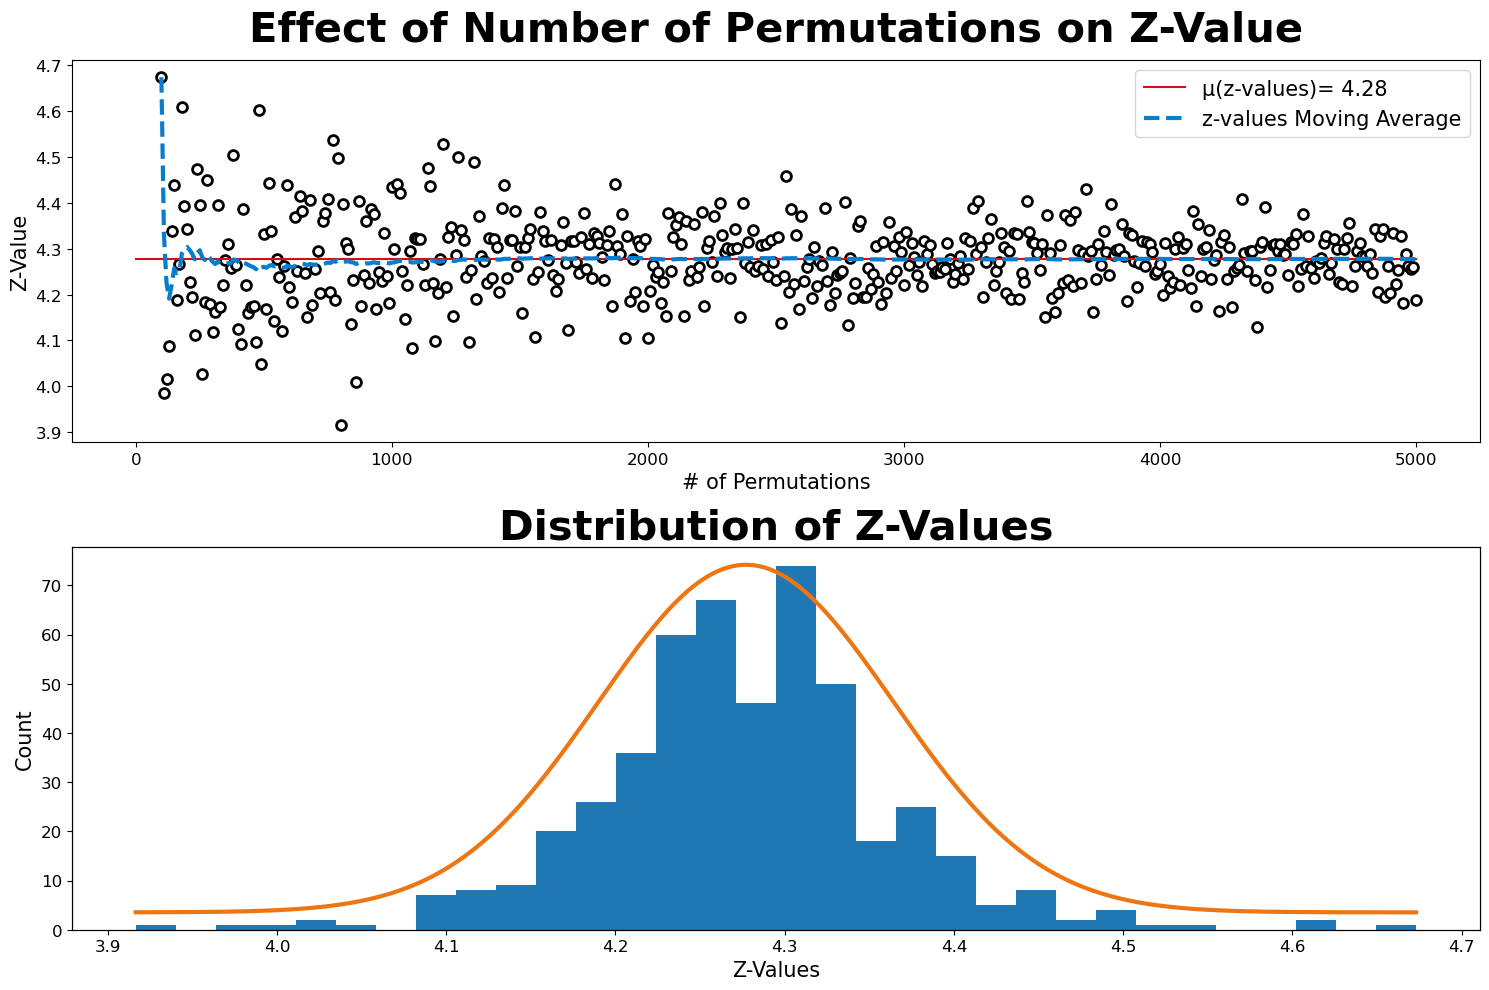

In [41]:
### NOTE: the z-value above is going to be different every time you run the analysis because we're generating an empricial null hypothesis distribution based on randomized data/random numbers
### So the z-value will be different everytime you run the test even if data doesn't change.
### We can use the law of large numbers and central limit theorem to get a more accurate population Z-value (we iterate calculating the z-value to get a normal distribution of them and take the center)

# See https://www.udemy.com/course/statsml_x/learn/lecture/20194576 for explanation

def plot_zscores(data_1, data_2, permutations):
    all_data = np.hstack((data_1, data_2))
    # conditions = np.hstack((np.ones(len(data_1)), 2*np.ones(len(data_2))))
    observed_diff = np.mean(data_2) - np.mean(data_1)
    
    
    z_values = np.zeros(len(permutations))
    z_values_ma = np.zeros(len(permutations))
    
    for i, perms in enumerate(permutations):
        perm_diffs = np.zeros(perms)
        
        for perm_i in range(perms):
            fconds = np.random.permutation(len(all_data))
            fconds[fconds < len(data_1)] = 1
            fconds[fconds > 1] = 2
            perm_diffs[perm_i] = np.mean(all_data[fconds == 2]) - np.mean(all_data[fconds == 1])
            
        z_val = (observed_diff - np.mean(perm_diffs)) / np.std(perm_diffs, ddof=1)
        z_values[i] = z_val
        z_values_ma[i] = np.mean(z_values[:i+1])
    
    zval_mean = np.mean(z_values)
    zval_std = np.std(z_values, ddof=1)
    zval_min = np.min(z_values)
    zval_max = np.max(z_values)
    
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,10))
    ax1.scatter(permutations, z_values, s=50, c='white', edgecolors='k', linewidths=2)
    ax1.plot([0,permutations[-1]],[zval_mean,zval_mean], color='#D21010', label=f'μ(z-values)= {np.round(zval_mean,2)}')
    ax1.plot(permutations, z_values_ma, color='#077DCE', linewidth=3, linestyle='--', label='z-values Moving Average')
    ax1.set_xlabel('# of Permutations', fontsize=15)
    ax1.set_ylabel('Z-Value', fontsize=15)
    ax1.set_title('Effect of Number of Permutations on Z-Value', fontsize=30, fontweight='semibold', y=1.03)
    ax1.tick_params(labelsize=12)
    ax1.legend(fontsize=15)
    
    ax2.hist(z_values, 'fd')
    ax2.set_xlabel('Z-Values', fontsize=15)
    ax2.set_ylabel('Count', fontsize=15)
    ax2.set_title('Distribution of Z-Values', fontsize=30, fontweight='semibold')
    ax2.tick_params(labelsize=12)
    
    ax3 = ax2.twinx()
    xx = np.linspace(zval_min,zval_max,1000)
    yy = stats.norm.pdf(xx, loc=zval_mean, scale=zval_std)
    ax3.plot(xx,yy, color='#EE7612', linewidth=3)
    ax3.set_yticks([])
    
    fig.tight_layout()
    plt.show()
    
    
# dataset "A"
r = np.random.randn(N)
r[r>0] = np.log(1+r[r>0])
dataA = 26-r*10
 
r = np.random.randn(N)
r[r>0] = np.log(1+r[r>0])
dataB = 30-r*10
 
plot_zscores(dataA, dataB, np.arange(100,5001,10))